In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:


import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


Loading the data 

In [4]:
training_data_1 = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_data_1 = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

In [5]:
training_data_1.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


 it can be seen that our training dataset has 3 Columns 
 * qid - Question Id as each question has an unique identifier 
 * question_text - Given question text
 * target - Determines wether a question is Insincere(1) or Not(0) .
 
Here it can be seen that targets for this dataset have value (0,1) only . Therefore this is a classification problem which is needed to be solved using text classification algorithms.

In [6]:
test_data_1.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


it can be seen that our test dataset has 2 Columns

* qid - Question Id as each question has an unique identifier
* question_text - Given question text


In [7]:
# getting information about the size of our dataset
print("Training Dataframe",training_data_1.shape)
print("Test Dataframe ",test_data_1.shape)

Train (1306122, 3)
Test (375806, 2)


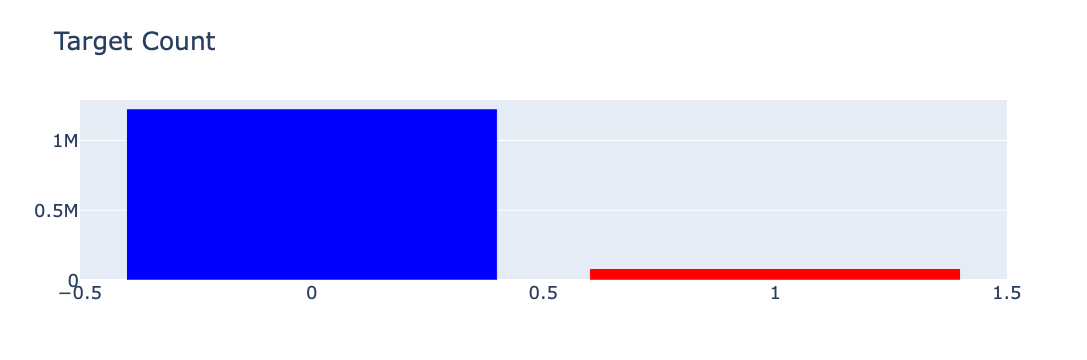

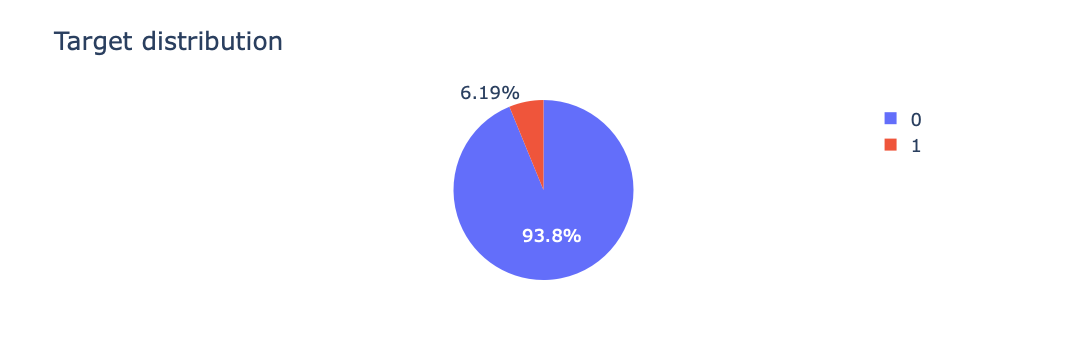

In [9]:
## target count ##
target_count_1 = training_data_1['target'].value_counts()
trace = go.Bar(
    x=target_count_1.index,
    y=target_count_1.values,
    marker=dict(
        color=target_count_1.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18),
    width=300,
    height = 300,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(target_count_1.index))
sizes = (np.array((target_count_1 / target_count_1.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=300,
    height=300,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [10]:
from wordcloud import WordCloud, STOPWORDS


/opt/conda/lib/python3.7/site-packages/plotly/tools.py:464: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



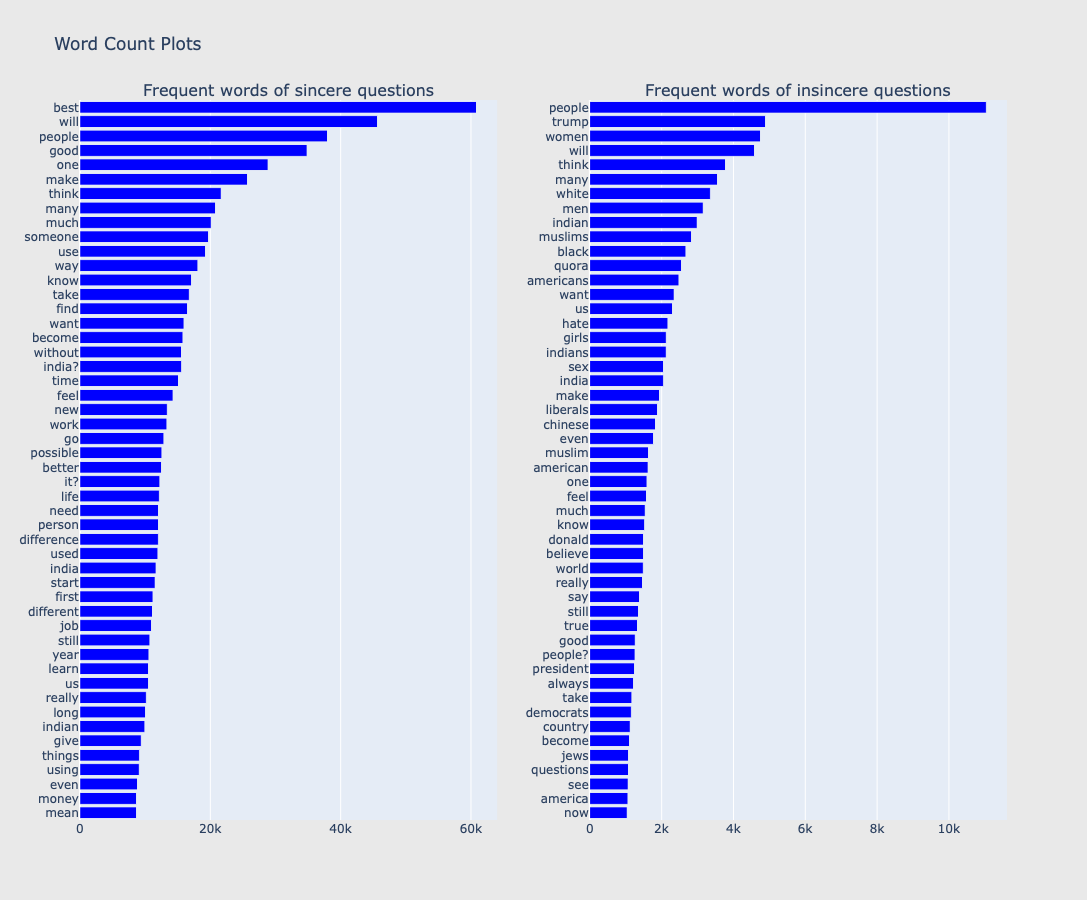

In [11]:
from collections import defaultdict
train1_df= training_data_1[training_data_1["target"]==1]
train0_df = training_data_1[training_data_1["target"]==0]

#function for unigram generation
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

#function for horizontal bar chart 
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# bar chart for Sincere Questions 
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

#bar chart for insincere questions 
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')


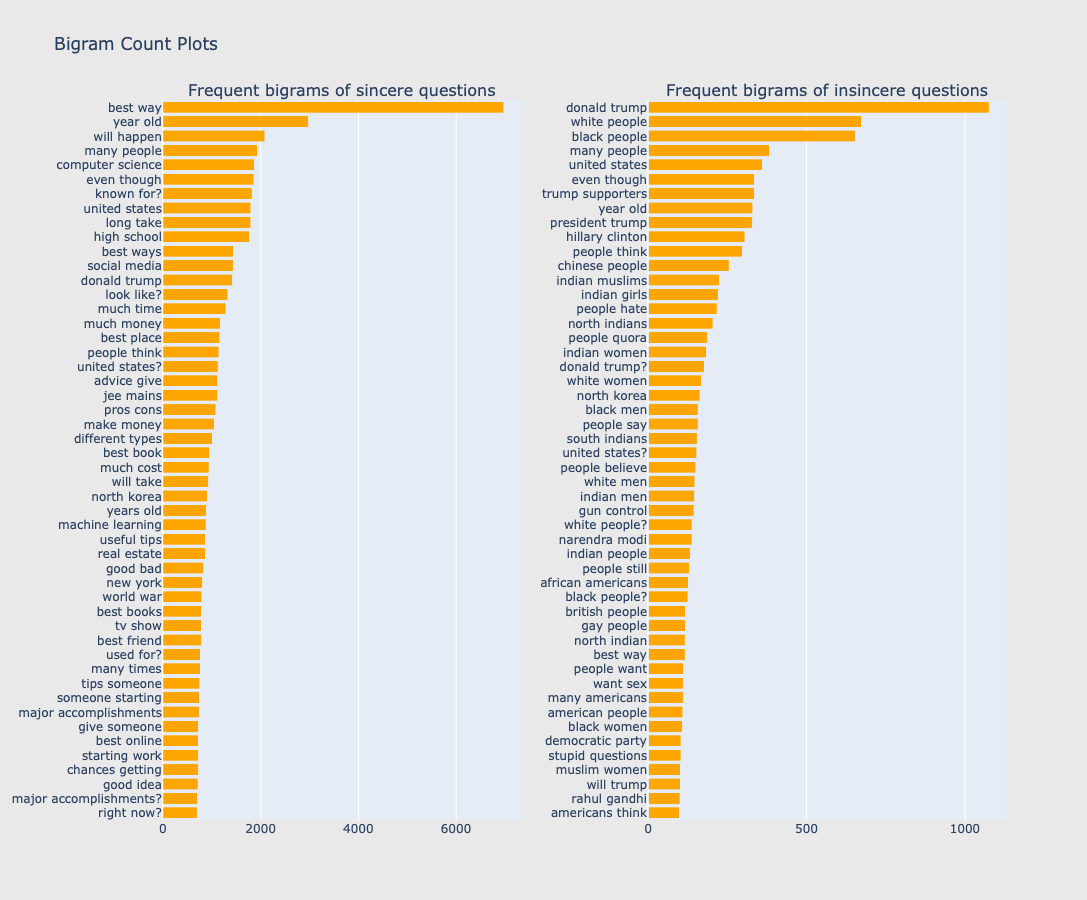

In [12]:
# similarly bigrams could be plotted using the same code just by modyfying the n_gram function and setting it to 2
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

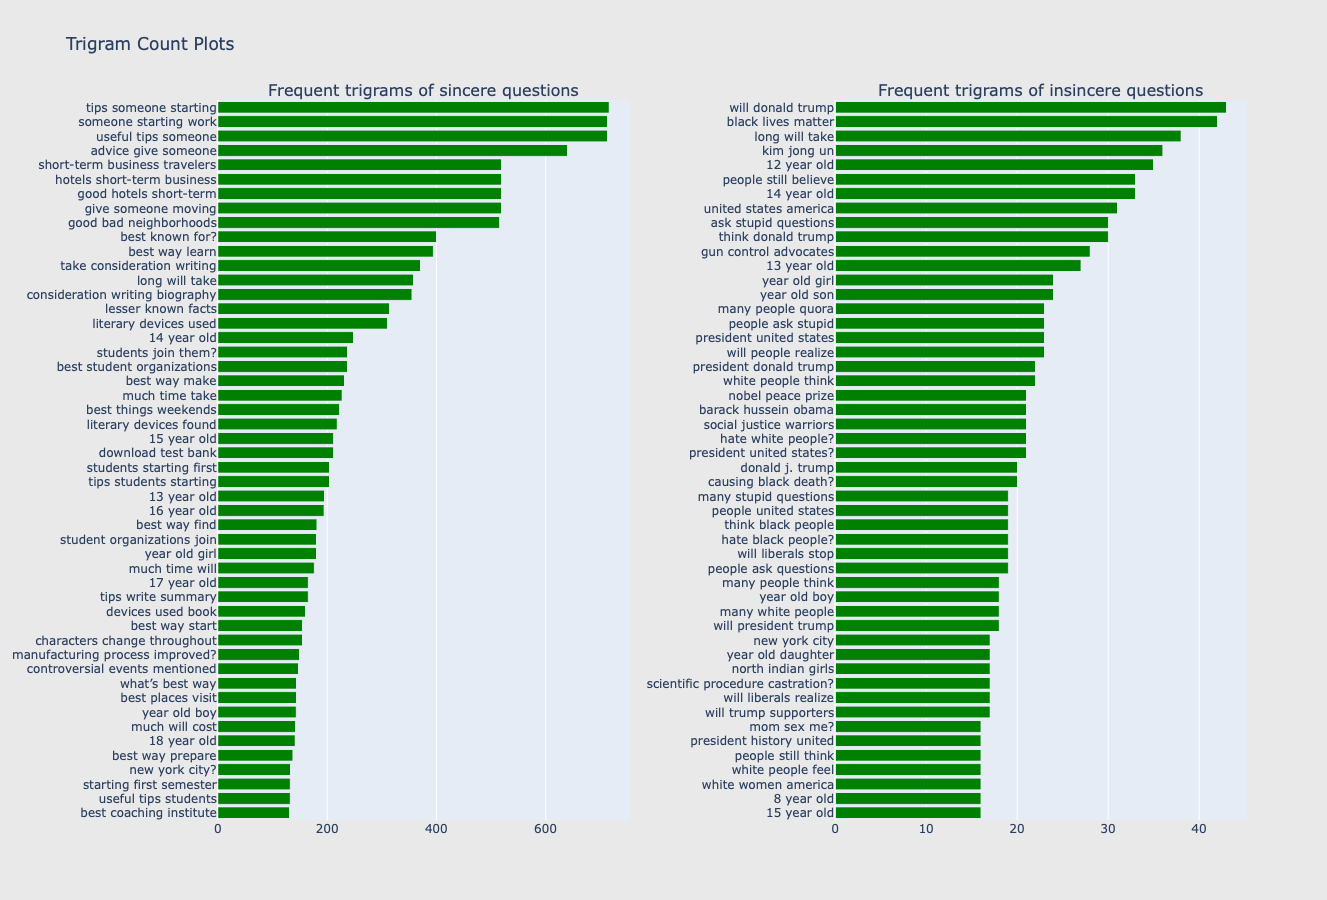

In [13]:
# similarly trigrams could be plotted using the same code just by modyfying the n_gram function and setting it to 3
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

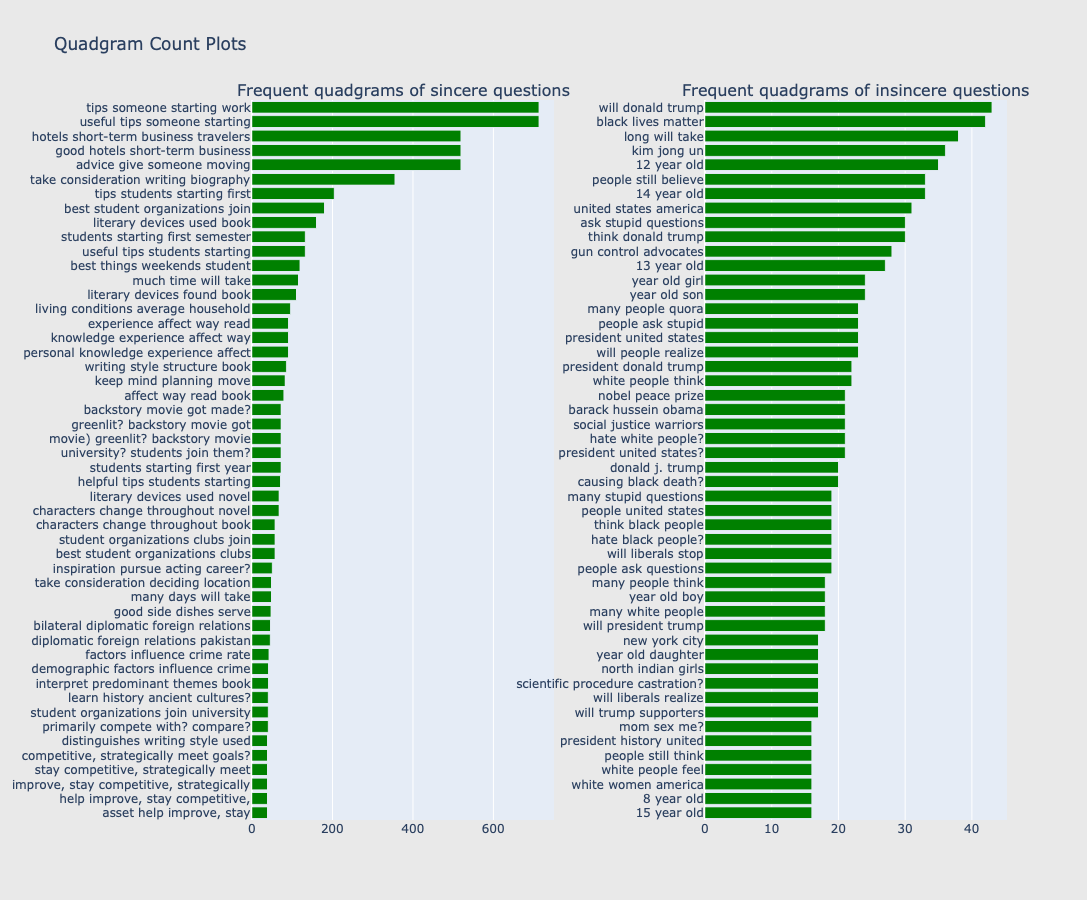

In [14]:
# similarly quadgrams could be plotted using the same code just by modyfying the n_gram function and setting it to 4
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent quadgrams of sincere questions", 
                                          "Frequent quadgrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Quadgram Count Plots")
py.iplot(fig, filename='word-plots')

# Using meta features to understand the data better 

In [22]:
# importing stopwords 
from nltk.corpus import stopwords

In [25]:
# setting stopwords and storing in a variable 
stopwords = set(stopwords.words('english'))

In [26]:
# Number of words 
training_data_1["#_of_words"] = training_data_1["question_text"].apply(lambda x: len(str(x).split()))
test_data_1["#_of_words"] = test_data_1["question_text"].apply(lambda x:len(str(x).split()))
# Number of unique words
training_data_1["#_unique_words"] = training_data_1["question_text"].apply(lambda x: len(set(str(x).split())))
test_data_1["#_unique_words"] = test_data_1["question_text"].apply(lambda x: len(set(str(x).split(x))))
# Number of characters  
training_data_1["#_of_chars"] = training_data_1["question_text"].apply(lambda x: len(str(x)))
test_data_1["#_of_chars"] = test_data_1["question_text"].apply(lambda x: len(str(x)))
# Number of stopwords
training_data_1["#_of_stopwords"] = training_data_1["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
test_data_1["#_of_stopwords"] = test_data_1["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
# Average length of the words 
training_data_1["mean_word_len"] = training_data_1["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data_1["mean_word_len"] = test_data_1["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# Number of punctuations
training_data_1["#_of_punctuations"] =training_data_1['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data_1["#_of_punctuations"] =test_data_1['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
# Average length of the words 
training_data_1["mean_word_length"] = training_data_1["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data_1["mean_word_length"] = test_data_1["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [28]:
training_data_1.head()

,qid,question_text,target,#_of_words,#_unique_words,#_of_chars,#_of_stopwords,mean_word_len,#_of_punctuations,#_words_upper,#_words_title,mean_word_length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,4.615385,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,9,4.125000,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,5.800000,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,5.444444,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,8,4.200000,1,2,3,4.200000


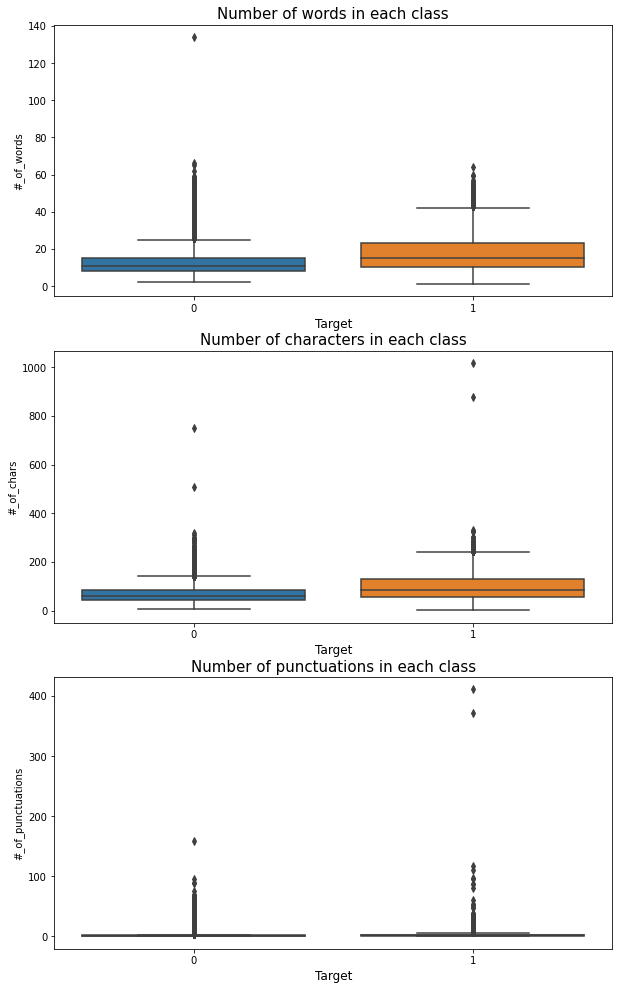

In [31]:
# plotting box plots and evaluating our meta-features 
f, axes = plt.subplots(3, 1, figsize=(10,17))
sns.boxplot(x='target', y='#_of_words', data=training_data_1, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='#_of_chars', data=training_data_1, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='#_of_punctuations', data=training_data_1, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()



# making a wordcloud to further understand the data

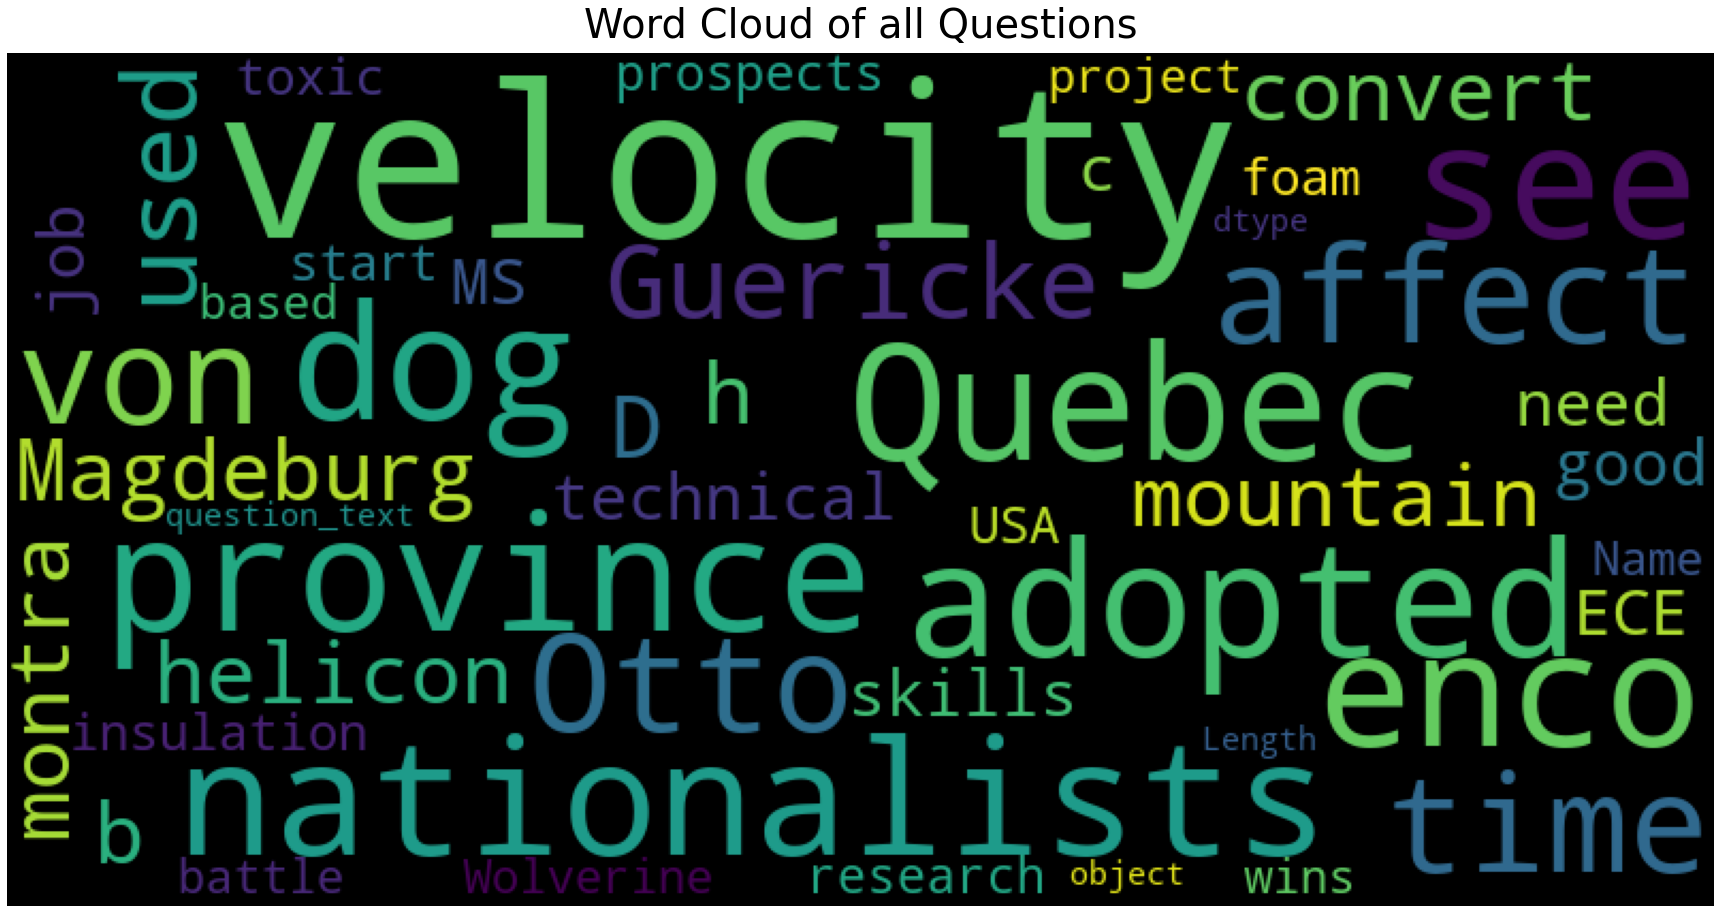

In [24]:
# making word cloud plot for complete training dataset 
def wordcloud_plot(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords_2 = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords_2 = stopwords_2.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords_2,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
wordcloud_plot(training_data_1["question_text"], title="Word Cloud of all Questions")

Average word length of questions in dataset is 13.
Max word length of questions in dataset is 134.
Average character length of questions in dataset is 71.


In [26]:
train_Insincere_words = training_data_1[training_data_1.target==1]
train_Sincere_words = training_data_1[training_data_1.target==0]

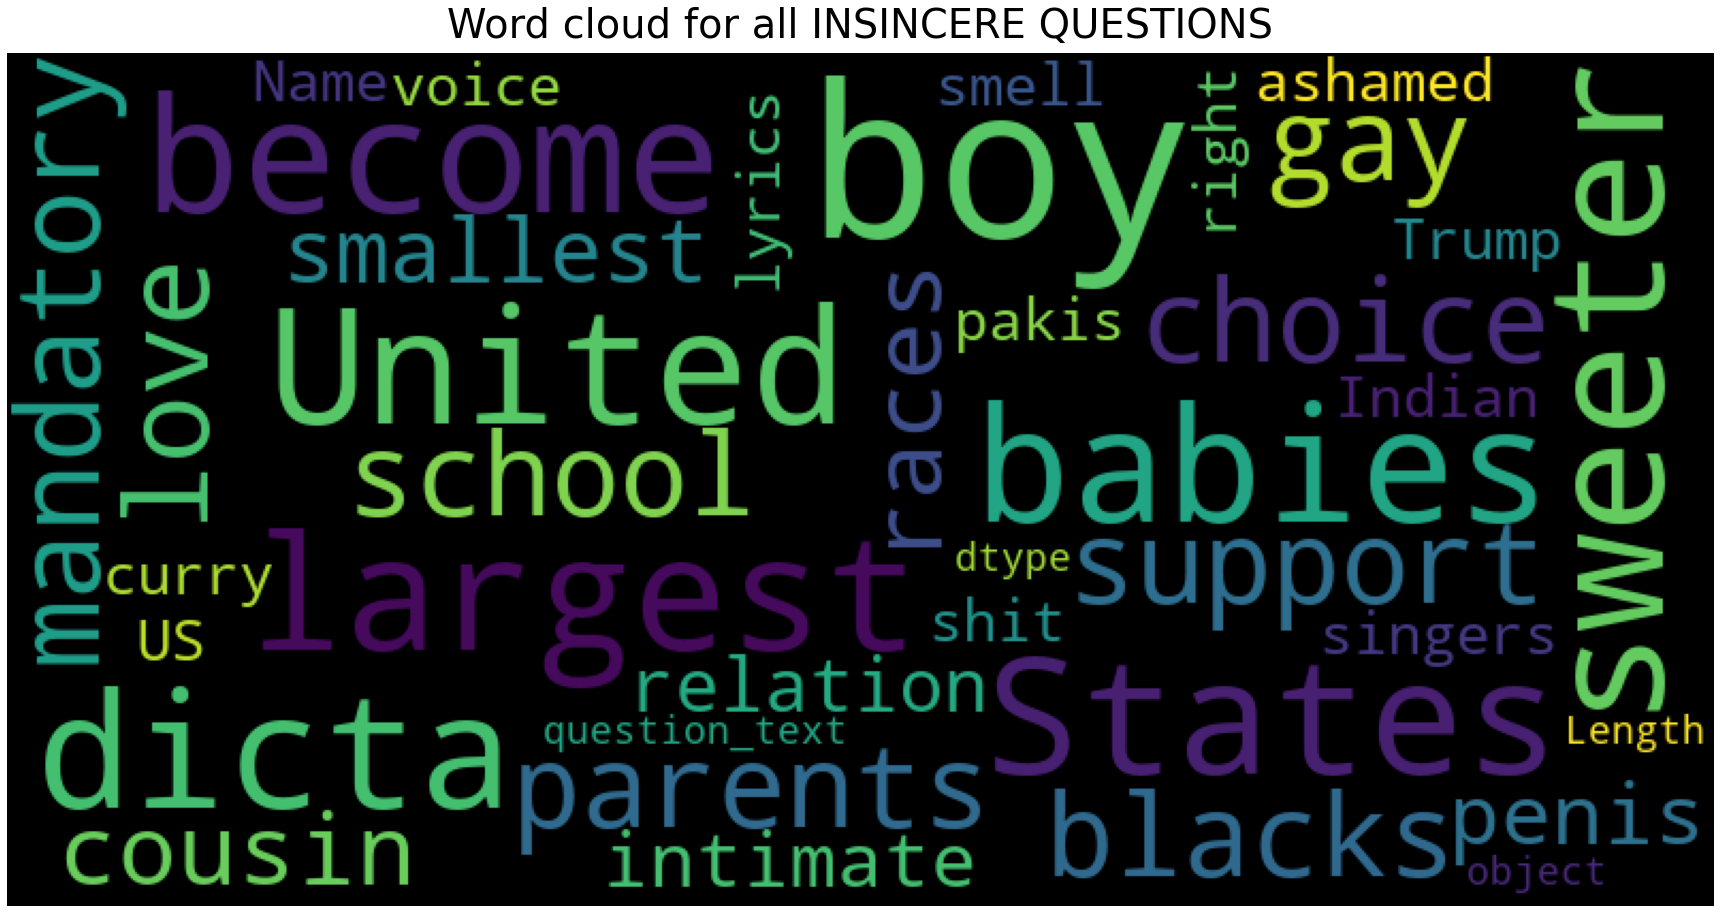

In [27]:
wordcloud_plot(train_Insincere_words['question_text'],title="Word cloud for all INSINCERE QUESTIONS")


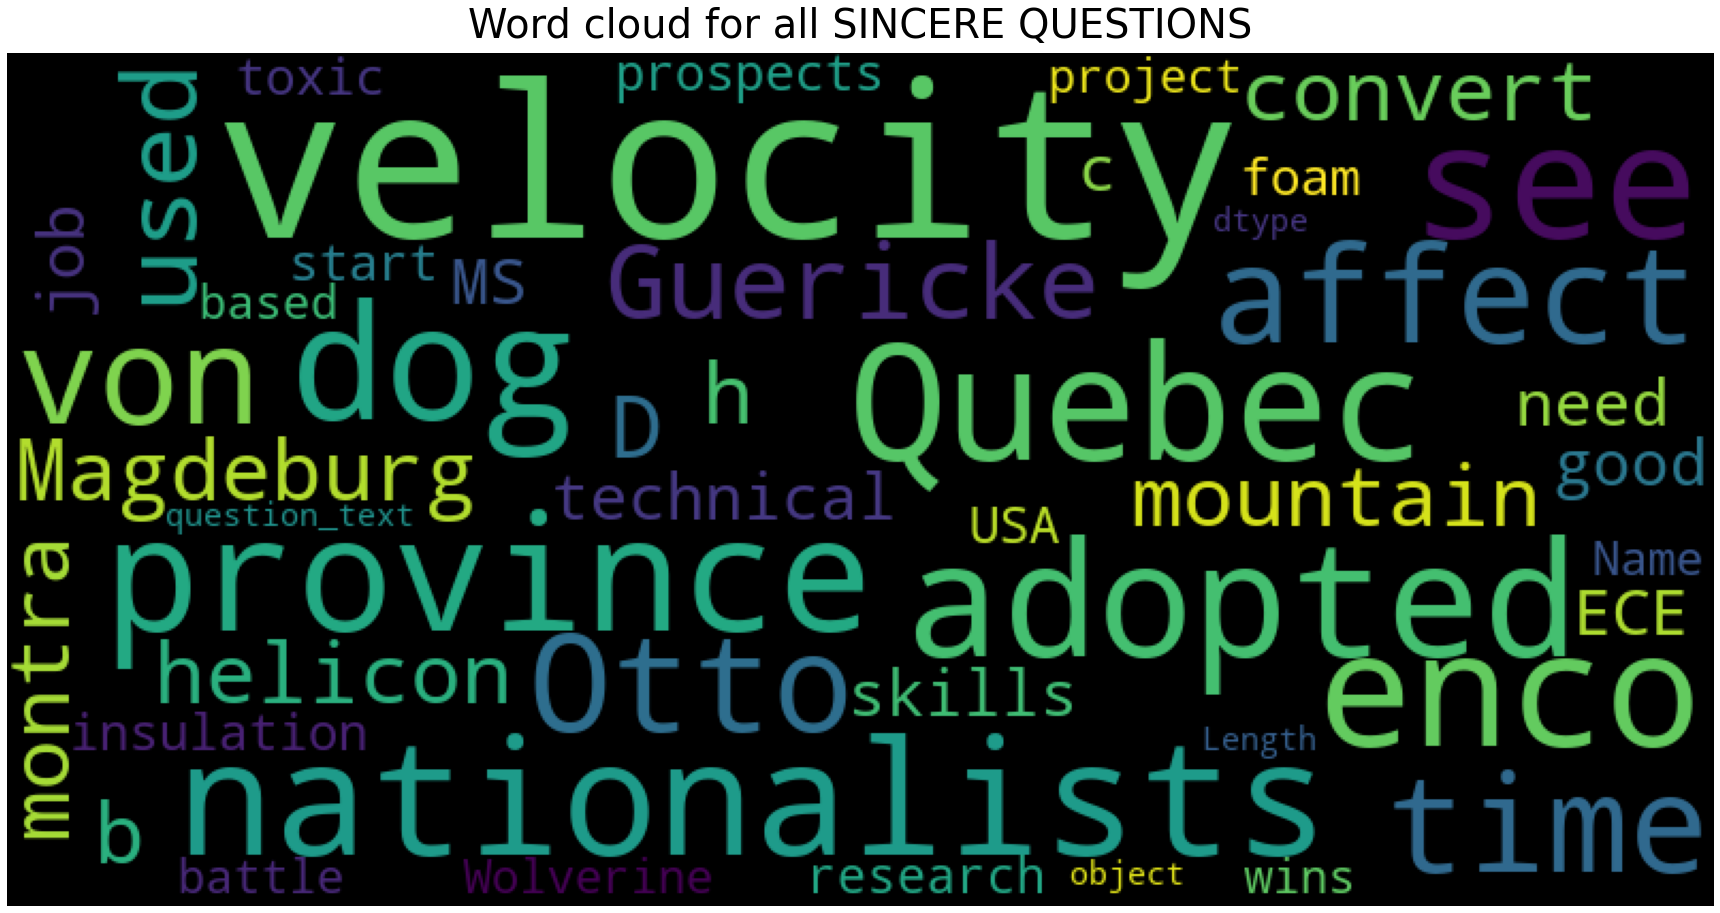

In [28]:
wordcloud_plot(train_Sincere_words['question_text'],title="Word cloud for all SINCERE QUESTIONS")


In [29]:
# TFIDF Vectorization for 
tfidf_vectors_1 = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vectors_1.fit_transform(train['question_text'].values.tolist() + test['question_text'].values.tolist())
train_tfidf_data = tfidf_vec.transform(train['question_text'].values.tolist())
test_tfidf_data = tfidf_vec.transform(test['question_text'].values.tolist())

# Baseline Model
- Logistic regression

In [30]:
train_y = training_data_1["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([training_data_1.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf_data[dev_index], train_tfidf_data[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf_data)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [31]:
for threshold in np.arange(0.1, 0.25, 0.01):
    threshold = np.round(threshold, 2)
    print("F1 score at threshold {0} is {1}".format(threshold, metrics.f1_score(val_y, (pred_val_y>threshold).astype(int))))

F1 score at threshold 0.1 is 0.5686754495282179
F1 score at threshold 0.11 is 0.5766786085750607
F1 score at threshold 0.12 is 0.5837343484402308
F1 score at threshold 0.13 is 0.5897296495823655
F1 score at threshold 0.14 is 0.5930953833638397
F1 score at threshold 0.15 is 0.5957213384530993
F1 score at threshold 0.16 is 0.596408595819841
F1 score at threshold 0.17 is 0.596942968279187
F1 score at threshold 0.18 is 0.5959782669579342
F1 score at threshold 0.19 is 0.5941465645364126
F1 score at threshold 0.2 is 0.5927026869499329
F1 score at threshold 0.21 is 0.5898798041252412
F1 score at threshold 0.22 is 0.5871947354122015
F1 score at threshold 0.23 is 0.584134393906821
F1 score at threshold 0.24 is 0.580862617814119


looking at the result it can be said that the best F1 Score is obtained at threshold 0.17